# WAV File Material Classifier

This notebook processes WAV recordings of different materials to classify them based on their acoustic signatures. The process is simplified compared to the M4A version since we can work with WAV files directly.

In [1]:
# Import required libraries
import os
import librosa
import numpy as np
import pandas as pd
import requests
import urllib.parse
from pathlib import Path
from supabase import create_client, Client
from dotenv import load_dotenv
from scipy.fft import fft
import matplotlib.pyplot as plt

# Constants for audio processing
AMBIENT_DURATION_SEC = 1.5  # Duration of ambient noise section

In [42]:
# Connect to Supabase
load_dotenv("../.env")

SUPABASE_URL = os.getenv("SUPABASE_URL")
SUPABASE_KEY = os.getenv("SUPABASE_KEY")

if not SUPABASE_URL or not SUPABASE_KEY:
    raise ValueError("❌ Missing SUPABASE_URL or SUPABASE_KEY in .env")

supabase: Client = create_client(SUPABASE_URL, SUPABASE_KEY)
print("✅ Connected to Supabase")

✅ Connected to Supabase


In [43]:
# Setup audio directory
AUDIO_DIR = Path("../audio/")
AUDIO_DIR.mkdir(parents=True, exist_ok=True)

# Get metadata from Supabase
response = supabase.table("recordings_metadata").select("*").execute()
df = pd.DataFrame(response.data)
print(f"✅ Loaded {len(df)} rows from Supabase recordings_metadata")
print("Columns:", df.columns.tolist())

✅ Loaded 12 rows from Supabase recordings_metadata
Columns: ['id', 'file_name', 'file_url', 'description', 'material', 'size', 'shape', 'timestamp', 'created_at', 'ambient_file_name', 'ambient_duration_ms']


In [44]:
# Download WAV files
for idx, row in df.iterrows():
    try:
        file_url = row.get("file_url")
        if not file_url:
            print(f"⚠️ Missing file_url for row {idx}")
            continue

        # Decode filename and check extension
        decoded_name = urllib.parse.unquote(os.path.basename(file_url))
        if not decoded_name.lower().endswith(".wav"):
            print(f"⏩ Skipping non-WAV file: {decoded_name}")
            continue

        local_path = AUDIO_DIR / decoded_name

        # Skip if already downloaded
        if local_path.exists():
            print(f"⏩ Skipping existing file: {decoded_name}")
            continue

        # Download file
        resp = requests.get(file_url, stream=True)
        if resp.status_code == 200:
            with open(local_path, "wb") as f:
                for chunk in resp.iter_content(chunk_size=8192):
                    f.write(chunk)
            print(f"✅ Saved {decoded_name}")
        else:
            print(f"⚠️ Skipped {decoded_name}: HTTP {resp.status_code}")

    except Exception as e:
        print(f"⚠️ Error downloading row {idx}: {e}")

⏩ Skipping existing file: Metal_Medium (4-10in)_Cylindrical_8oz tall can_2025-11-10T18-43-18_full.wav
⏩ Skipping existing file: Metal_Medium (4-10in)_Cylindrical_8oz tall can_2025-11-10T18-48-12_full.wav
⏩ Skipping existing file: Metal_Medium (4-10in)_Cylindrical_8oz tall can_2025-11-10T18-50-59_full.wav
✅ Saved Plastic_Large_10in-plus_Cylindrical_Coke_bottle__2025-11-11T17-59-11_full.wav
✅ Saved Plastic_Large_10in-plus_Cylindrical_Coke_bottle_2025-11-11T18-01-21_full.wav
✅ Saved Paper_Medium_4-10in_Crushed_Moes_bag_2025-11-11T18-06-31_full.wav
⏩ Skipping existing file: Metal_Medium (4-10in)_Cylindrical_8oz tall can_2025-11-10T18-45-49_full.wav
⏩ Skipping existing file: Metal_Medium (4-10in)_Cylindrical_8oz can_2025-11-10T18-49-37_full.wav
✅ Saved Plastic_Large_10in-plus_Cylindrical_Coke_bottle_2025-11-11T17-58-05_full.wav
✅ Saved Plastic_Large_10in-plus_Cylindrical_Coke_bottle_2025-11-11T18-00-44_full.wav
✅ Saved Paper_Medium_4-10in_Crushed_Moes_bag_2025-11-11T18-02-30_full.wav
✅ Save

In [45]:
def load_audio(filepath, target_sr=44100):
    """Load WAV file directly using librosa. Much simpler than the M4A version!"""
    try:
        # Load audio file with librosa
        audio, sr = librosa.load(filepath, sr=target_sr, mono=True, 
                               duration=AMBIENT_DURATION_SEC * 2)
        return sr, audio
    except Exception as e:
        print(f"❌ Error loading {filepath}: {e}")
        return None, None

# Test the loading function
test_file = next(AUDIO_DIR.glob("*.wav"))
print(f"Testing with file: {test_file}")
sr, audio = load_audio(test_file)
if sr is not None:
    print(f"✅ Successfully loaded audio: {len(audio)} samples @ {sr}Hz")
    print(f"Duration: {len(audio)/sr:.2f} seconds")
else:
    print("❌ Failed to load audio")

Testing with file: ..\audio\Metal_Medium (4-10in)_Cylindrical_8oz can_2025-11-10T18-49-37_full.wav
✅ Successfully loaded audio: 132300 samples @ 44100Hz
Duration: 3.00 seconds


✅ Successfully extracted 33075 features


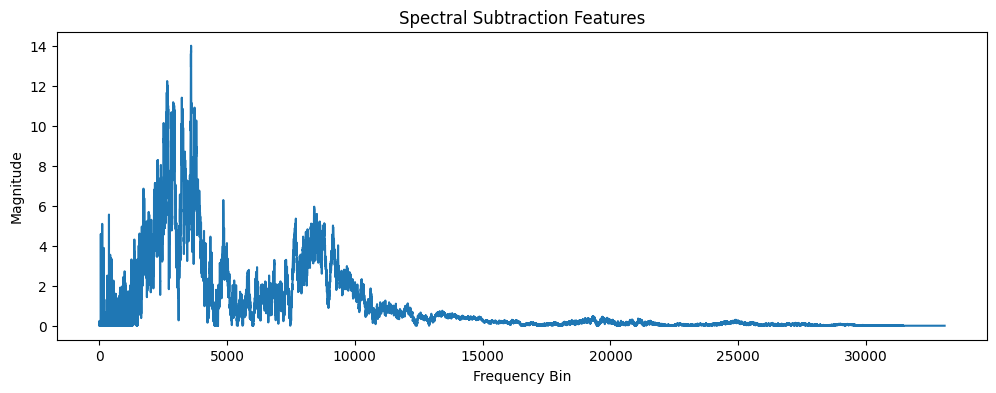

In [46]:
def spectral_subtraction(ambient, chirp):
    """Subtracts ambient FFT magnitude from chirp FFT magnitude"""
    n = min(len(ambient), len(chirp))
    ambient = ambient[:n]
    chirp = chirp[:n]

    fft_ambient = np.abs(fft(ambient))
    fft_chirp = np.abs(fft(chirp))

    clean_fft = np.maximum(fft_chirp - fft_ambient, 0)
    return clean_fft[:n // 2]  # use positive frequencies only

def extract_features(filepath):
    """Extract spectral subtraction features; returns None if audio invalid/too short."""
    sr, y = load_audio(str(filepath))
    if sr is None or y is None or len(y) < 2:
        return None
    split_sample = int(sr * AMBIENT_DURATION_SEC)
    if len(y) < split_sample * 2:
        return None
    ambient = y[:split_sample]
    chirp = y[split_sample:]
    return spectral_subtraction(ambient, chirp)

# Test feature extraction
test_features = extract_features(test_file)
if test_features is not None:
    print(f"✅ Successfully extracted {len(test_features)} features")
    
    # Plot the features
    plt.figure(figsize=(12, 4))
    plt.plot(test_features)
    plt.title("Spectral Subtraction Features")
    plt.xlabel("Frequency Bin")
    plt.ylabel("Magnitude")
    plt.show()

In [47]:
# Extract features for all files
X, y = [], []

for idx, row in df.iterrows():
    material = row.get("material")
    file_url = row.get("file_url")
    if not file_url or not material:
        continue
    decoded_name = urllib.parse.unquote(os.path.basename(file_url))
    local_path = AUDIO_DIR / decoded_name
    if not local_path.exists():
        print(f"⚠️ Missing local file: {decoded_name}")
        continue
    feat = extract_features(str(local_path))
    if feat is None:
        print(f"⚠️ Skipped {decoded_name}: could not extract features")
        continue
    X.append(feat)
    y.append(material)

X = np.array(X)
y = np.array(y)
print(f"✅ FFT feature extraction complete! Features: {X.shape}, Labels: {y.shape}")

# Print dataset information
print("\nDataset size:")
print(f"Total samples: {len(X)}")
unique_materials = np.unique(y)
for material in unique_materials:
    count = sum(y == material)
    print(f"{material}: {count} samples")

✅ FFT feature extraction complete! Features: (12, 33075), Labels: (12,)

Dataset size:
Total samples: 12
Metal: 5 samples
Paper: 3 samples
Plastic: 4 samples



Metadata Distribution:

Size Distribution:
small (0-4in): 0 samples
medium (4-10in): 5 samples
large (>10in): 0 samples

Shape Distribution:
Flat: 0 samples
Crushed: 3 samples
Cylindrical: 9 samples
Irregular: 0 samples
Spherical: 0 samples

Classification Report:
              precision    recall  f1-score   support

       Metal       1.00      1.00      1.00         1
       Paper       0.00      0.00      0.00         1
     Plastic       0.50      1.00      0.67         1

    accuracy                           0.67         3
   macro avg       0.50      0.67      0.56         3
weighted avg       0.50      0.67      0.56         3



c:\Users\savir\MaterialClassifier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\savir\MaterialClassifier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\savir\MaterialClassifier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

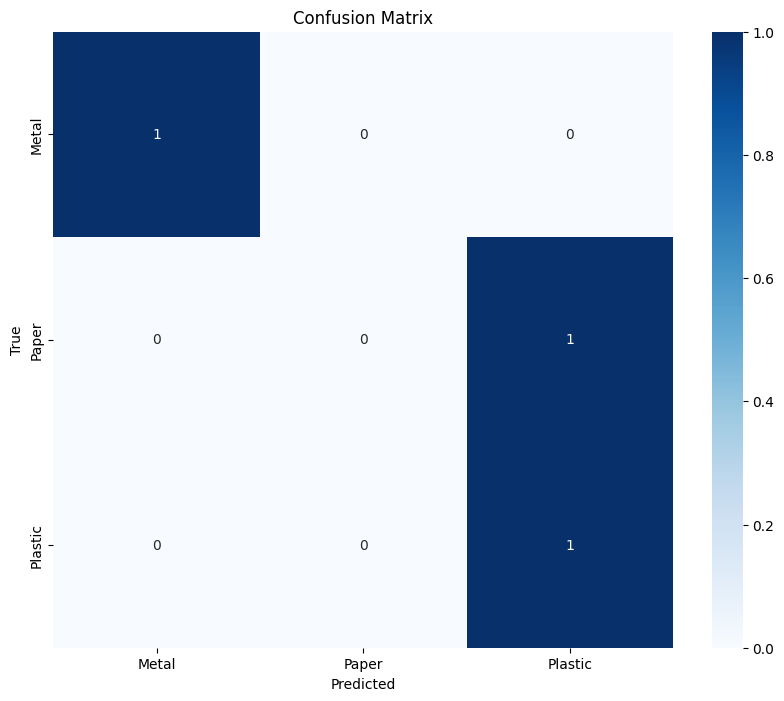

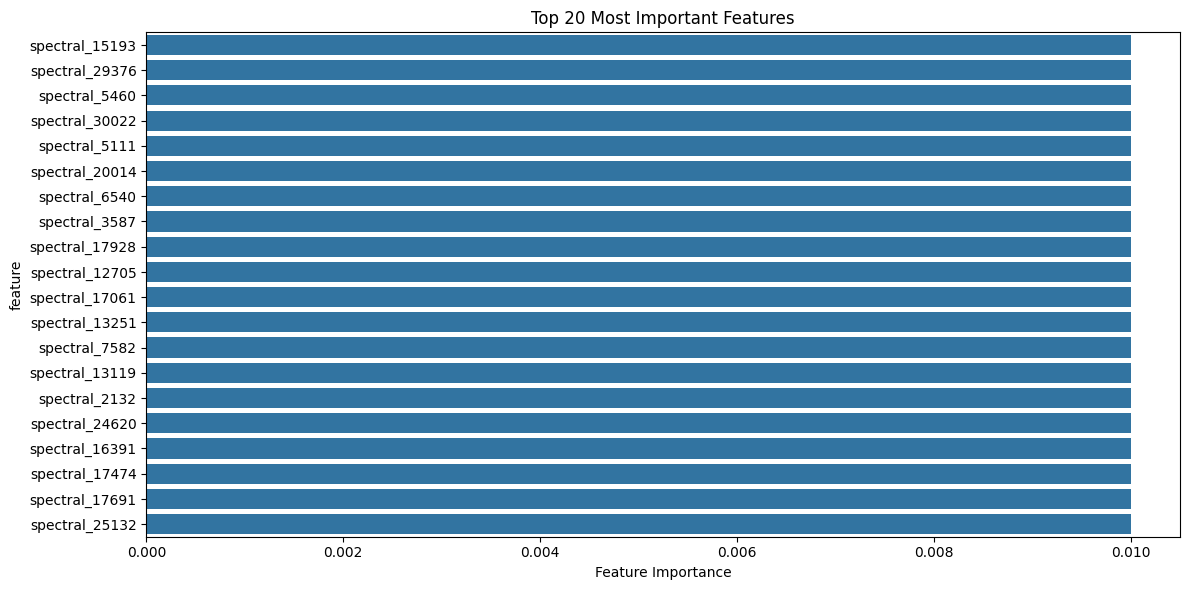

In [48]:
# Prepare the dataset with additional metadata features
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Define size and shape mappings
SIZE_MAPPING = {
    'small (0-4in)': 0,   # 0-4 inches
    'medium (4-10in)': 1,  # 4-10 inches
    'large (>10in)': 2    # >10 inches
}

SHAPE_MAPPING = {
    'Flat': 0,
    'Crushed': 1,
    'Cylindrical': 2,
    'Irregular': 3,
    'Spherical': 4
}

# Create feature matrix with spectral data and metadata
X_combined = []
for idx in range(len(X)):
    spectral_features = X[idx]
    row = df.iloc[idx]  # Get the corresponding metadata row
    
    # Get metadata features with defaults
    size = row.get('size', 'medium (4-10in)').lower()  # Default to medium
    shape = row.get('shape', 'Irregular')     # Default to Irregular
    
    # Convert size to numeric
    size_numeric = SIZE_MAPPING.get(size, SIZE_MAPPING['medium (4-10in)'])
    
    # Convert shape to numeric
    shape_numeric = SHAPE_MAPPING.get(shape, SHAPE_MAPPING['Irregular'])
    
    # Combine spectral features with metadata
    combined_features = np.concatenate([
        spectral_features,
        [size_numeric, shape_numeric]  # Add metadata features
    ])
    X_combined.append(combined_features)

X_combined = np.array(X_combined)

# Print metadata distribution
print("\nMetadata Distribution:")
print("\nSize Distribution:")
sizes = [df.iloc[i].get('size', 'medium (4-10in)').lower() for i in range(len(X))]
for size in SIZE_MAPPING.keys():
    count = sum(s == size for s in sizes)
    print(f"{size}: {count} samples")

print("\nShape Distribution:")
shapes = [df.iloc[i].get('shape', 'Irregular') for i in range(len(X))]
for shape in SHAPE_MAPPING.keys():
    count = sum(s == shape for s in shapes)
    print(f"{shape}: {count} samples")

# Encode the material labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y_encoded, test_size=0.2, random_state=42
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test_scaled)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Feature importance analysis
n_spectral = X.shape[1]
feature_names = ([f'spectral_{i}' for i in range(n_spectral)] + 
                ['size', 'shape'])
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_classifier.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot top 20 most important features
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', 
            data=feature_importance.head(20))
plt.title('Top 20 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()